Name: Will Gleave
swg8jq

In [46]:
#import libraries
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sagemaker import get_execution_role
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType, DoubleType

In [ ]:
#configure spark context
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

In [13]:
#specify file location
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'swg8jq/FootballEurope.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pddf = pd.read_csv(data_location, dtype = object) #reading as strings, spark having issues with columns

In [14]:
#clean up data
pddf = pddf.dropna()
pddf.drop('Unnamed: 0', axis = 1, inplace = True)

In [15]:
#spark df from pandas
df = sqlc.createDataFrame(pddf)

In [ ]:
#specify parquet path
parquetPath = '/home/ec2-user/SageMaker/swg8jq/tmp-pqt2'
df.write.parquet(parquetPath)

In [17]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "sample_data/pqt/"+f)


In [18]:
#write df to parquet
df = sqlc.read.parquet(parquetPath)

In [19]:
#print schema
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- homeTacklesTotalHT: string (nullable = true)
 |-- homeShotsTotalHT: string (nullable = true)
 |-- awayDispossessedFT: string (nullable = true)
 |-- awayPassSuccessFT: string (nullable = true)
 |-- awayRatingsFT: string (nullable = true)
 |-- awayDribbleSuccessFT: string (nullable = true)
 |-- awayDribblesAttemptedHT: string (nullable = true)
 |-- awayTeamLineUp: string (nullable = true)
 |-- awayShotsBlockedHT: string (nullable = true)
 |-- awayShotsTotalHT: string (nullable = true)
 |-- homeDribbleSuccessHT: string (nullable = true)
 |-- homeFoulsCommitedFT: string (nullable = true)
 |-- homeAerialsTotalFT: string (nullable = true)
 |-- homeRatingsHT: string (nullable = true)
 |-- awayShotsOnTargetFT: string (nullable = true)
 |-- awayShotsBlockedFT: string (nullable = true)
 |-- homeInterceptionsHT: string (nullable = true)
 |-- awayPossessionHT: string (nullable = true)
 |-- homePassesKeyFT: string (nullable = true)
 |-- awayShotsOnTargetH

In [20]:
#only select specific columns
df = df.select("homeGoalFT","homeDribbleSuccessFT", "homePassesKeyFT", "homeCornersTotalFT", "homeShotsTotalFT",
              "homeTacklesTotalFT", "homeAerialsTotalFT", "homeShotsOnTargetFT", "homeOffsidesCaughtFT")

In [21]:
#change datatypes

floatval = ["homeDribbleSuccessFT",]

intval = ["homeGoalFT","homePassesKeyFT", "homeCornersTotalFT", "homeShotsTotalFT",
              "homeTacklesTotalFT", "homeAerialsTotalFT", "homeShotsOnTargetFT", "homeOffsidesCaughtFT"]

for col in intval:
    df = df.withColumn(col, df[col].cast(IntegerType()))

for col in floatval:
    df = df.withColumn(col, df[col].cast(DoubleType()))    

df.printSchema()

root
 |-- homeGoalFT: integer (nullable = true)
 |-- homeDribbleSuccessFT: double (nullable = true)
 |-- homePassesKeyFT: integer (nullable = true)
 |-- homeCornersTotalFT: integer (nullable = true)
 |-- homeShotsTotalFT: integer (nullable = true)
 |-- homeTacklesTotalFT: integer (nullable = true)
 |-- homeAerialsTotalFT: integer (nullable = true)
 |-- homeShotsOnTargetFT: integer (nullable = true)
 |-- homeOffsidesCaughtFT: integer (nullable = true)



In [22]:
# create train/test sets
seed = 23
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 6561, test set N = 1708


In [24]:
#use vectorassembler to create vectors

assembler = VectorAssembler(
    inputCols=["homeDribbleSuccessFT", "homePassesKeyFT", "homeCornersTotalFT", "homeShotsTotalFT",
              "homeTacklesTotalFT", "homeAerialsTotalFT", "homeShotsOnTargetFT", "homeOffsidesCaughtFT"],
    outputCol="features")

vectrainDF = assembler.transform(trainingDF)
vectestDF = assembler.transform(testDF)

In [25]:
# rename to make ML engine happy
vectrainDF = vectrainDF.withColumnRenamed("homeGoalFT", "label").withColumnRenamed("features", "features")
vectestDF = vectestDF.withColumnRenamed("homeGoalFT", "label").withColumnRenamed("features", "features")

In [26]:
vectrainDF.take(5)

[Row(label=0, homeDribbleSuccessFT=0.0, homePassesKeyFT=0, homeCornersTotalFT=0, homeShotsTotalFT=0, homeTacklesTotalFT=0, homeAerialsTotalFT=0, homeShotsOnTargetFT=0, homeOffsidesCaughtFT=0, features=SparseVector(8, {})),
 Row(label=0, homeDribbleSuccessFT=0.0, homePassesKeyFT=4, homeCornersTotalFT=1, homeShotsTotalFT=9, homeTacklesTotalFT=31, homeAerialsTotalFT=30, homeShotsOnTargetFT=0, homeOffsidesCaughtFT=4, features=DenseVector([0.0, 4.0, 1.0, 9.0, 31.0, 30.0, 0.0, 4.0])),
 Row(label=0, homeDribbleSuccessFT=0.0, homePassesKeyFT=13, homeCornersTotalFT=8, homeShotsTotalFT=18, homeTacklesTotalFT=20, homeAerialsTotalFT=20, homeShotsOnTargetFT=4, homeOffsidesCaughtFT=1, features=DenseVector([0.0, 13.0, 8.0, 18.0, 20.0, 20.0, 4.0, 1.0])),
 Row(label=0, homeDribbleSuccessFT=5.0, homePassesKeyFT=3, homeCornersTotalFT=8, homeShotsTotalFT=5, homeTacklesTotalFT=33, homeAerialsTotalFT=30, homeShotsOnTargetFT=0, homeOffsidesCaughtFT=1, features=DenseVector([5.0, 3.0, 8.0, 5.0, 33.0, 30.0, 0.0

In [27]:
#create gradient boosted tree regressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'label',maxIter=10)

In [28]:
#fit model
model = gbt.fit(vectrainDF)

In [29]:
#transform to get predictions on test data
predictions = model.transform(vectestDF)

In [107]:
predictions.take(5)

[Row(label=0, homeDribbleSuccessFT=0.0, homePassesKeyFT=2, homeCornersTotalFT=6, homeShotsTotalFT=3, homeTacklesTotalFT=29, homeAerialsTotalFT=28, homeShotsOnTargetFT=1, homeOffsidesCaughtFT=2, features=DenseVector([0.0, 2.0, 6.0, 3.0, 29.0, 28.0, 1.0, 2.0]), prediction=0.3415661123723515),
 Row(label=0, homeDribbleSuccessFT=0.0, homePassesKeyFT=11, homeCornersTotalFT=6, homeShotsTotalFT=14, homeTacklesTotalFT=29, homeAerialsTotalFT=21, homeShotsOnTargetFT=2, homeOffsidesCaughtFT=1, features=DenseVector([0.0, 11.0, 6.0, 14.0, 29.0, 21.0, 2.0, 1.0]), prediction=0.5084320185371448),
 Row(label=0, homeDribbleSuccessFT=4.76, homePassesKeyFT=7, homeCornersTotalFT=6, homeShotsTotalFT=8, homeTacklesTotalFT=23, homeAerialsTotalFT=24, homeShotsOnTargetFT=1, homeOffsidesCaughtFT=0, features=DenseVector([4.76, 7.0, 6.0, 8.0, 23.0, 24.0, 1.0, 0.0]), prediction=0.2973612451082771),
 Row(label=0, homeDribbleSuccessFT=8.33, homePassesKeyFT=8, homeCornersTotalFT=6, homeShotsTotalFT=9, homeTacklesTotal

In [30]:
#evaluate predictions
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.07145


In [32]:
#try linear regression model

lr = LinearRegression()
lrModel = lr.fit(vectrainDF)

predictionsAndLabelsDF = lrModel.transform(vectestDF)

rmse2 = evaluator.evaluate(predictionsAndLabelsDF)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse2)

Root Mean Squared Error (RMSE) on test data = 1.06188


In [53]:
#df back to pandas to plot results
pandaspred = predictions.toPandas()

In [54]:
#make new column for prediction error
pandaspred['error'] =  pandaspred['prediction'] - pandaspred['label']

In [55]:
#make all error positive
pandaspred['error'] = pandaspred.apply(lambda x: np.absolute(x['error']), axis=1)

Text(0,0.5,'Number of Games')

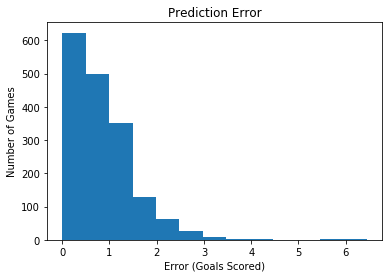

In [71]:
#plot histogram of error
plt.hist(pandaspred['error'], bins = 13)
plt.title('Prediction Error')
plt.xlabel('Error (Goals Scored)')
plt.ylabel('Number of Games')